First we gather the data in one ETF such as XLF, then we define a return column such that for each holding we have: 

$$Return=\frac{Openning price-Closing price}{opening price}$$

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from investiny import historical_data, search_assets
import yahooquery as yq

import requests
from bs4 import BeautifulSoup

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox


import numpy as np
import seaborn as sns
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from scipy.stats import anderson, zscore, norm
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
sns.set(style="darkgrid", palette = 'bright')

In [4]:
xlf_ticker = 'XLF'

In [5]:
etf_info = search_assets(xlf_ticker)

In [6]:
etf_info[0]

{'symbol': 'XLF',
 'full_name': 'NYSE:XLF',
 'description': 'Financial Select Sector SPDR® Fund',
 'type': 'ETF',
 'ticker': '40668',
 'exchange': 'NYSE'}

In [7]:
etf = yq.Ticker(xlf_ticker)

holdings = etf.fund_holding_info 

In [8]:
holdings['XLF']['holdings']

[{'symbol': 'BRK-B',
  'holdingName': 'Berkshire Hathaway Inc Class B',
  'holdingPercent': 0.1299437},
 {'symbol': 'JPM',
  'holdingName': 'JPMorgan Chase & Co',
  'holdingPercent': 0.0998032},
 {'symbol': 'V',
  'holdingName': 'Visa Inc Class A',
  'holdingPercent': 0.0764973},
 {'symbol': 'MA',
  'holdingName': 'Mastercard Inc Class A',
  'holdingPercent': 0.0670354},
 {'symbol': 'BAC',
  'holdingName': 'Bank of America Corp',
  'holdingPercent': 0.045904897},
 {'symbol': 'WFC',
  'holdingName': 'Wells Fargo & Co',
  'holdingPercent': 0.0384686},
 {'symbol': 'GS',
  'holdingName': 'The Goldman Sachs Group Inc',
  'holdingPercent': 0.0250957},
 {'symbol': 'AXP',
  'holdingName': 'American Express Co',
  'holdingPercent': 0.0240611},
 {'symbol': 'SPGI',
  'holdingName': 'S&P Global Inc',
  'holdingPercent': 0.0240208},
 {'symbol': 'PGR',
  'holdingName': 'Progressive Corp',
  'holdingPercent': 0.021914301}]

In [6]:
# Search for the ETF
etfs = investiny.search_etfs(by='name', value=xlf_ticker)
print(etfs)

AttributeError: module 'investiny' has no attribute 'search_etfs'

In [15]:
etf = yf.Ticker(xlf_ticker)

# Get all holdings in the ETF
holdings = etf.fund_holding_info

AttributeError: 'Ticker' object has no attribute 'fund_holding_info'

In [9]:
etf.info

AttributeError: 'Ticker' object has no attribute 'info'

In [12]:

# Top holdings in XLF
top_holdings_tickers = [
    'BRK-B',  # Berkshire Hathaway Inc.
    'JPM',    # JPMorgan Chase & Co.
    'V',      # Visa Inc.
    'MA',     # Mastercard Incorporated
    'BAC',    # Bank of America Corporation
    'WFC',    # Wells Fargo & Company
    'C',      # Citigroup Inc.
    'GS',     # Goldman Sachs Group Inc.
    'MS'      # Morgan Stanley
]
start_date = '2009-01-01'
end_date = '2023-01-01'

# Fetch data from Yahoo Finance from start to end date
def fetch_data(ticker, start, end):
    data = yf.download(ticker, start=start, end=end)
    data['Ticker'] = ticker
    return data


xlf_data = fetch_data(xlf_ticker, start_date, end_date) # Fetch data for XLF
holdings_data = {ticker: fetch_data(ticker, start_date, end_date) for ticker in top_holdings_tickers} # Fetch data for each top holding
combined_data = xlf_data[['Open', 'Adj Close', 'Volume']].rename(columns={'Adj Close': 'Adj Close_XLF', 'Volume': 'Volume_XLF', 'Open': 'Open_XLF'}) # Rename columns to include ticker
combined_data['Ticker_XLF'] = xlf_ticker # Add ticker column

# Combine data for each top holding
for ticker, data in holdings_data.items():
    combined_data = combined_data.join(
        data[['Open', 'Adj Close', 'Volume']].rename(columns={
            'Adj Close': f'Adj Close_{ticker}',
            'Volume': f'Volume_{ticker}',
            'Open': f'Open_{ticker}'
        })
    )

combined_data.index.name = 'Date'

# Calculate returns for each ticker
combined_data['Return_XLF'] = (combined_data['Adj Close_XLF'] - combined_data['Open_XLF']) / combined_data['Open_XLF']

# Calculate returns for each top holding
for ticker in top_holdings_tickers:
    combined_data[f'Return_{ticker}'] = (combined_data[f'Adj Close_{ticker}'] - combined_data[f'Open_{ticker}']) / combined_data[f'Open_{ticker}']

combined_data.index.name = 'Date'

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Then we can try to graph the return:

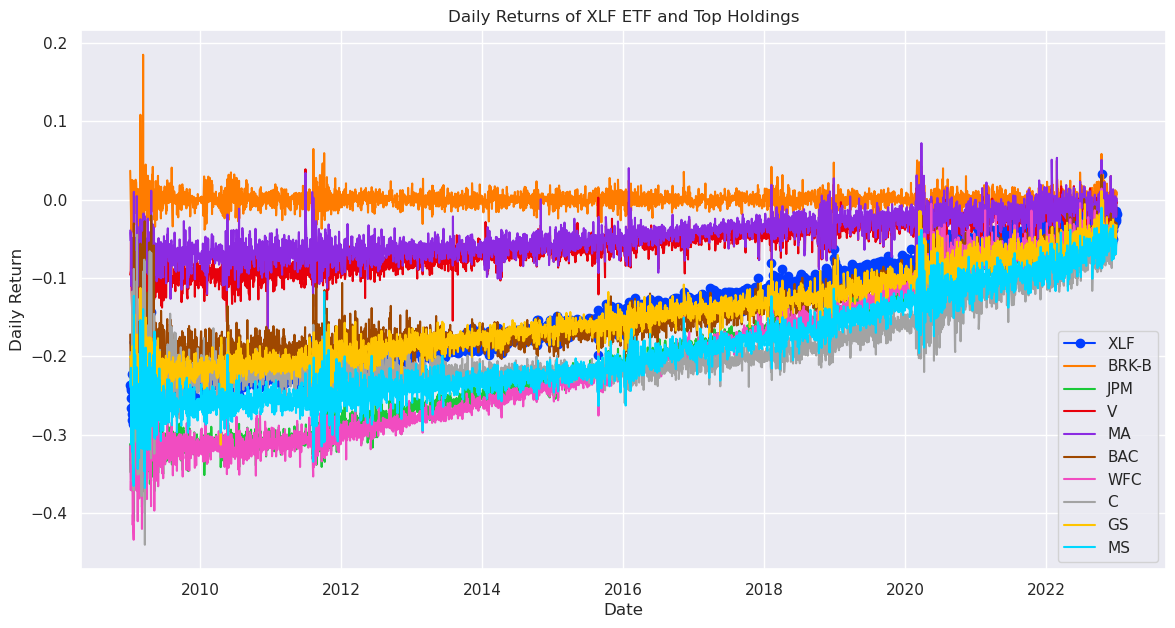

In [13]:
# Plot daily returns for XLF and top holdings
plt.figure(figsize=(14, 7)) 
plt.plot(combined_data.index, combined_data['Return_XLF'], label='XLF', linestyle='-', marker='o')
for ticker in top_holdings_tickers:
    plt.plot(combined_data.index, combined_data[f'Return_{ticker}'], label=ticker)
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Daily Returns of XLF ETF and Top Holdings')
plt.legend()
plt.grid(True)
plt.show()

As you see all the returns follows an increasing trend except for BRK-B. Now we can find the correlation matrix between the daily return column:

In [14]:
return_columns = ['Return_XLF'] + [f'Return_{ticker}' for ticker in top_holdings_tickers]
returns_df = combined_data[return_columns]
correlation_matrix = returns_df.corr()

In [15]:
correlation_matrix

,Return_XLF,Return_BRK-B,Return_JPM,Return_V,Return_MA,Return_BAC,Return_WFC,Return_C,Return_GS,Return_MS
Return_XLF,1.000000,0.098556,0.995686,0.920354,0.853487,0.944786,0.992813,0.878905,0.985094,0.974283
Return_BRK-B,0.098556,1.000000,0.066629,0.167799,0.226847,0.172165,0.067074,0.159678,0.123947,0.124975
Return_JPM,0.995686,0.066629,1.000000,0.910224,0.841966,0.938118,0.991893,0.873144,0.983022,0.972488
Return_V,0.920354,0.167799,0.910224,1.000000,0.920300,0.855155,0.904539,0.780311,0.905876,0.886025
Return_MA,0.853487,0.226847,0.841966,0.920300,1.000000,0.825948,0.839361,0.766287,0.844418,0.843488
Return_BAC,0.944786,0.172165,0.938118,0.855155,0.825948,1.000000,0.941475,0.942785,0.944287,0.959740
Return_WFC,0.992813,0.067074,0.991893,0.904539,0.839361,0.941475,1.000000,0.876631,0.976294,0.970776
Return_C,0.878905,0.159678,0.873144,0.780311,0.766287,0.942785,0.876631,1.000000,0.890703,0.923597
Return_GS,0.985094,0.123947,0.983022,0.905876,0.844418,0.944287,0.976294,0.890703,1.000000,0.978647
Return_MS,0.974283,0.124975,0.972488,0.886025,0.843488,0.959740,0.970776,0.923597,0.978647,1.000000


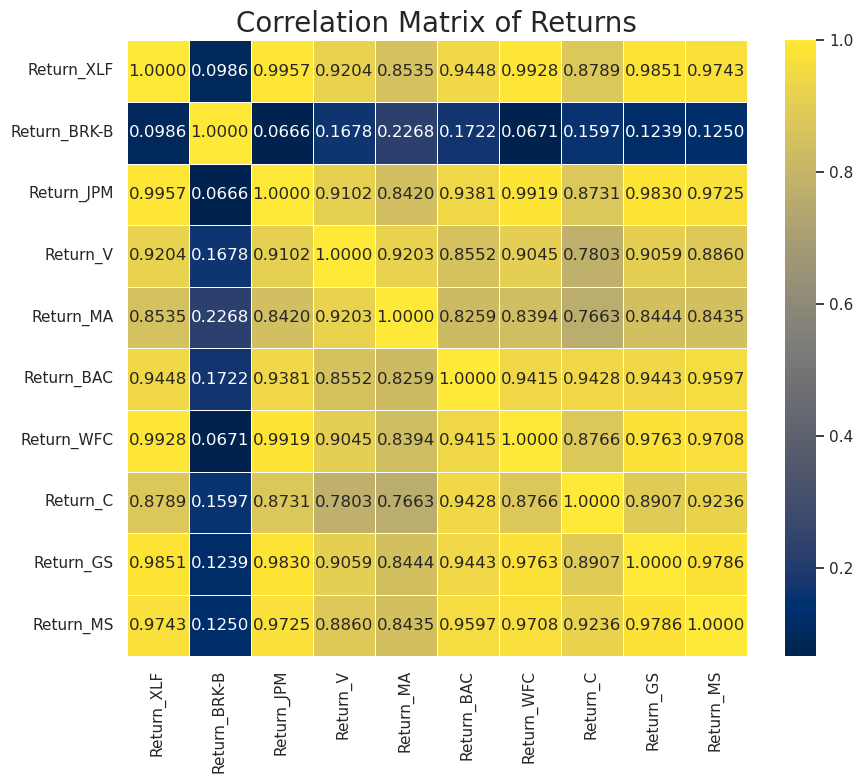

In [16]:
# Create a heatmap to visualize the covariance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='cividis', fmt='.4f', linewidths=.5)
plt.title('Correlation Matrix of Returns', fontsize=20)
plt.show()

The data seems to be highly correlated from this point of view, Now we define the rolling correlation which is a statistical measure that calculate the relationship between two specific variable, in an specific amount of time. for example here we use the quarter 90 days minus the number of weekends so the window we are using here is 365-number of weekends. Then we drop the NAs from the data and we have the following result: 

In [17]:
window = 63
rolling_correlations = pd.DataFrame(index=combined_data.index)

for ticker in top_holdings_tickers:
    # Calculate rolling correlation between XLF and each top holding
    rolling_correlations[f'Corr_{ticker}'] = combined_data['Return_XLF'].rolling(window).corr(combined_data[f'Return_{ticker}'])

rolling_correlations = rolling_correlations.dropna()

In [18]:
rolling_correlations

,Corr_BRK-B,Corr_JPM,Corr_V,Corr_MA,Corr_BAC,Corr_WFC,Corr_C,Corr_GS,Corr_MS
Date,,,,,,,,,
2009-04-02,0.521323,0.898559,0.704643,0.693072,0.842662,0.888935,0.753143,0.849010,0.804170
2009-04-03,0.527961,0.898376,0.708512,0.703908,0.844399,0.891402,0.753880,0.851538,0.807406
2009-04-06,0.527262,0.899235,0.710722,0.706435,0.844661,0.892369,0.754245,0.853748,0.810335
2009-04-07,0.523381,0.898840,0.718073,0.703532,0.844793,0.895558,0.753887,0.856347,0.814620
2009-04-08,0.519889,0.898336,0.717978,0.702552,0.843885,0.895008,0.756890,0.853480,0.810751
...,...,...,...,...,...,...,...,...,...
2022-12-23,0.914337,0.850968,0.706174,0.785946,0.864400,0.833559,0.751741,0.880927,0.772850
2022-12-27,0.914359,0.850631,0.701259,0.786019,0.862472,0.834079,0.747171,0.875445,0.762689
2022-12-28,0.913490,0.850159,0.699185,0.778078,0.857308,0.828092,0.743964,0.871891,0.759026


In [19]:
# Calculate the 30-day rolling standard deviation of returns and drop NaN values
moving_average_30d = combined_data['Return_XLF'].rolling(window=21).std()

# Calculate the annualized volatility using the mean of the rolling standard deviations
yearly_volatility = moving_average_30d.mean() * np.sqrt(252)

# Print the result
print(f'The 30-day moving average volatility of {ticker} is {round(np.mean(yearly_volatility * 100), 2)}%')


The 30-day moving average volatility of MS is 14.62%


In [28]:
for i in combined_data.columns:
    if i.startswith('Return'):
        print(i)
        # Calculate the 30-day rolling standard deviation of returns and drop NaN values
        moving_average_30d = combined_data[i].rolling(window=21).std()
        
        # Calculate the annualized volatility using the mean of the rolling standard deviations
        yearly_volatility = moving_average_30d.mean() * np.sqrt(252)
        
        # Print the result
        print(f'The 30-day moving average volatility of {ticker} is {round(np.mean(yearly_volatility * 100), 2)}%')

Return_XLF
The 30-day moving average volatility of MS is 14.62%
Return_BRK-B
The 30-day moving average volatility of MS is 15.15%
Return_JPM
The 30-day moving average volatility of MS is 17.29%
Return_V
The 30-day moving average volatility of MS is 18.9%
Return_MA
The 30-day moving average volatility of MS is 21.1%
Return_BAC
The 30-day moving average volatility of MS is 23.46%
Return_WFC
The 30-day moving average volatility of MS is 19.01%
Return_C
The 30-day moving average volatility of MS is 22.26%
Return_GS
The 30-day moving average volatility of MS is 19.12%
Return_MS
The 30-day moving average volatility of MS is 21.54%


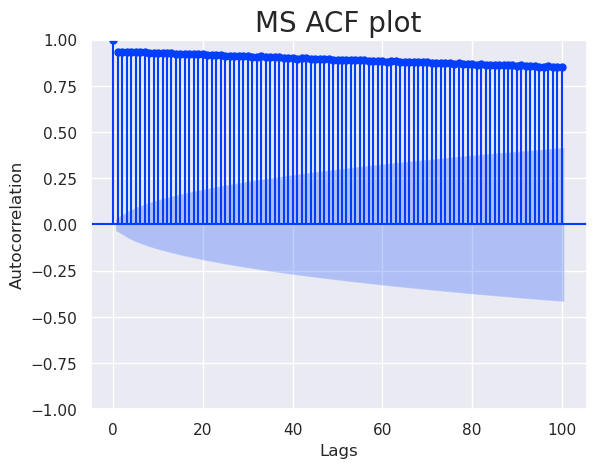

In [36]:
# Plot the autocorrelation function (ACF) plot
plot_acf(combined_data['Return_MS'], lags=100)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title(''.join(['MS', ' ACF plot']), size = 20)
plt.show()

The GARCH(1,1) line represents represents (annualized) daily volatility predictions that were modeled over the training period.


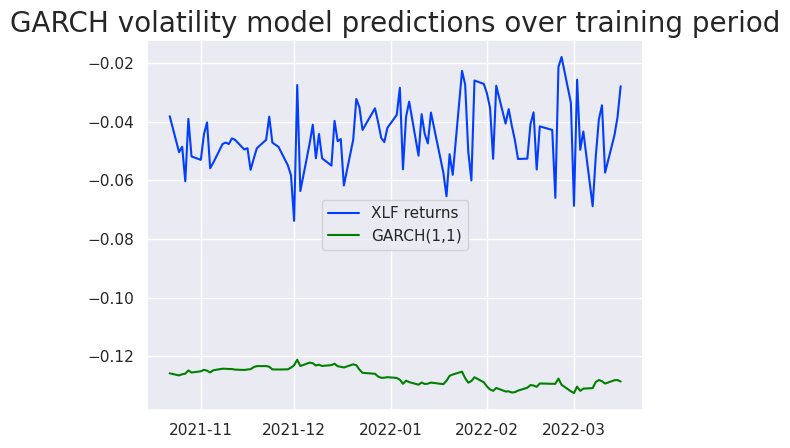

GARCH(1,1) forecasted volatility over testing period: 1.3010530942999645
-------
Realized volatility over testing period: 0.15683165950499592
-------
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Return_XLF   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9350.24
Distribution:                  Normal   AIC:                           18708.5
Method:            Maximum Likelihood   BIC:                           18732.9
                                        No. Observations:                 3324
Date:                Fri, May 31 2024   Df Residuals:                     3323
Time:                        01:53:36   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf

/tmp/ipykernel_17376/974845074.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  real_vol = testing_set.rolling(window = 21).std()[-1]*np.sqrt(252)


In [34]:
returns_data = combined_data['Return_XLF'].dropna()

# Split Data into Training and Testing Sets
testing_days = 200
testing_set = returns_data[-testing_days:]
training_set = returns_data[:-testing_days]
training_set_scaled = 100*training_set #Multiplying by 100 makes the model run more accurately. Have to rescale outputs accordingly.

#Perform GARCH Modeling on the Training Set
garch_model = arch_model(training_set_scaled, vol='Garch', p=1, q=1) 
results = garch_model.fit(disp='off')


# Calculate GARCH conditional volatility for the testing set
garch_volatility = results.conditional_volatility/100
projected_results = results.forecast(horizon = testing_days, reindex = 'False')

projected_results_variance = projected_results.variance.iloc[-1].values/100 #Rescale values
forecasted_vol = np.sqrt(projected_results_variance).mean()


print('The GARCH(1,1) line represents represents (annualized) daily volatility predictions that were modeled over the training period.')
plt.plot(training_set[-100:], label = ''.join(['XLF', ' returns']))
plt.plot(-garch_volatility[-100:],color = 'green', label = 'GARCH(1,1)')
plt.title('GARCH volatility model predictions over training period', size = 20)
plt.legend()
plt.show()


print(f'GARCH(1,1) forecasted volatility over testing period: {forecasted_vol}')
print('-------')
real_vol = testing_set.rolling(window = 21).std()[-1]*np.sqrt(252)
print(f'Realized volatility over testing period: {real_vol}')
print('-------')
print(results)

Then we want to choose the one that has correlation less than 10% and we restore them as outsiders.

In [6]:
# Idenify outsiders based on rolling correlation threshold of 0.20
def identify_outsiders(correlations, threshold=0.20):
    quantile_threshold = correlations.quantile(threshold, axis=1)
    outsiders = correlations.apply(lambda x: x < quantile_threshold, axis=0)
    return outsiders

outsiders = identify_outsiders(rolling_correlations)
outsiders

,Corr_BRK-B,Corr_JPM,Corr_BAC,Corr_WFC,Corr_C,Corr_GS,Corr_MS
Date,,,,,,,
2000-03-31,False,False,False,False,False,True,True
2000-04-03,True,False,False,False,False,True,False
2000-04-04,True,False,False,False,False,True,False
2000-04-05,True,False,False,False,False,True,False
2000-04-06,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...
2022-12-23,False,False,False,False,True,False,True
2022-12-27,False,False,False,False,True,False,True
2022-12-28,False,False,False,False,True,False,True


Then we determine "outsider" stocks at different points in time.

In [7]:
quarters = combined_data.resample('Q').last().index

quarterly_outsiders = {}

for quarter_end in quarters:
    quarter_correlations = rolling_correlations.loc[:quarter_end].tail(1)
    outsiders = identify_outsiders(quarter_correlations)
    quarterly_outsiders[quarter_end] = outsiders


/tmp/ipykernel_17227/4130653408.py:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarters = combined_data.resample('Q').last().index


At last, Compute average return differences between the portfolio of "outsider" stocks and the ETF.

In [8]:
outsiders.shape

(1, 7)

In [10]:
outsiders

,Corr_BRK-B,Corr_JPM,Corr_BAC,Corr_WFC,Corr_C,Corr_GS,Corr_MS
Date,,,,,,,
2022-12-30,False,False,False,False,True,False,True


In [16]:
return_differences = []

# Calculate average return difference between outsiders and XLF for each quarter
for quarter_end in combined_data.resample('Q').last().index:
    print(quarter_end)
    # outsiders_for_quarter = outsiders.loc[quarter_end]
    #outsider_stocks = outsiders_for_quarter.index[outsiders_for_quarter].tolist()

#     if outsider_stocks:
#         outsider_returns = combined_data.iloc[combined_data.index.get_loc(quarter_end):combined_data.index.get_loc(quarter_end + pd.DateOffset(days=40)), 1:][outsider_stocks].mean(axis=1).mean()
#         etf_returns = combined_data.iloc[combined_data.index.get_loc(quarter_end):combined_data.index.get_loc(quarter_end + pd.DateOffset(days=40)), 1:]['Return_XLF'].mean()

#         return_difference = outsider_returns - etf_returns
#         return_differences.append(return_difference)

# average_return_difference = sum(return_differences) / len(return_differences)
# print(f'\nAverage return difference: {average_return_difference:.4f}')


2000-03-31 00:00:00
2000-06-30 00:00:00
2000-09-30 00:00:00
2000-12-31 00:00:00
2001-03-31 00:00:00
2001-06-30 00:00:00
2001-09-30 00:00:00
2001-12-31 00:00:00
2002-03-31 00:00:00
2002-06-30 00:00:00
2002-09-30 00:00:00
2002-12-31 00:00:00
2003-03-31 00:00:00
2003-06-30 00:00:00
2003-09-30 00:00:00
2003-12-31 00:00:00
2004-03-31 00:00:00
2004-06-30 00:00:00
2004-09-30 00:00:00
2004-12-31 00:00:00
2005-03-31 00:00:00
2005-06-30 00:00:00
2005-09-30 00:00:00
2005-12-31 00:00:00
2006-03-31 00:00:00
2006-06-30 00:00:00
2006-09-30 00:00:00
2006-12-31 00:00:00
2007-03-31 00:00:00
2007-06-30 00:00:00
2007-09-30 00:00:00
2007-12-31 00:00:00
2008-03-31 00:00:00
2008-06-30 00:00:00
2008-09-30 00:00:00
2008-12-31 00:00:00
2009-03-31 00:00:00
2009-06-30 00:00:00
2009-09-30 00:00:00
2009-12-31 00:00:00
2010-03-31 00:00:00
2010-06-30 00:00:00
2010-09-30 00:00:00
2010-12-31 00:00:00
2011-03-31 00:00:00
2011-06-30 00:00:00
2011-09-30 00:00:00
2011-12-31 00:00:00
2012-03-31 00:00:00
2012-06-30 00:00:00


/tmp/ipykernel_17227/3187213737.py:4: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  for quarter_end in combined_data.resample('Q').last().index:


In [17]:
outsiders

,Corr_BRK-B,Corr_JPM,Corr_BAC,Corr_WFC,Corr_C,Corr_GS,Corr_MS
Date,,,,,,,
2022-12-30,False,False,False,False,True,False,True
